In [121]:
#configure the github repo
!rm -rf objectdetector_tf_test
!git clone https://github.com/lkoshale/objectdetector_tf_test.git
  

Cloning into 'objectdetector_tf_test'...
remote: Counting objects: 83, done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 83 (delta 32), reused 64 (delta 16), pack-reused 0
Unpacking objects: 100% (83/83), done.


In [3]:
#import files
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO

from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
# sys.path.append("..")

import ops as utils_ops

In [5]:
if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
import label_map_util

import visualization_utils as vis_util
import viz_edit3 as vis_util_new
from matplotlib import pyplot as plt

In [8]:
#generate file names

MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
BASEREPO = 'objectdetector_tf_test/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [9]:
#import grah from .pb file
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [10]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [11]:
#function to load images
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [17]:
#generate path for each image
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1,3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [13]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict


In [15]:
#plotiing figure
import cv2
import math
%matplotlib inline

In [0]:
def crop_img_save()

19 324 24 555
412 997 69 589


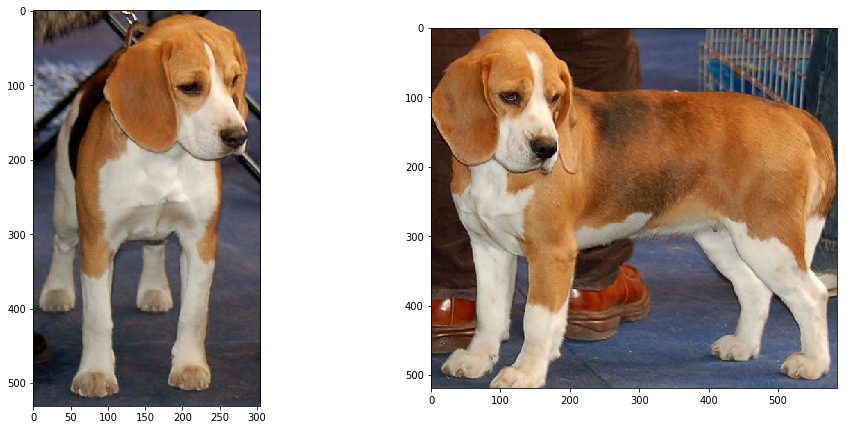

(636, 1024, 3)
532 554 498 534
467 486 344 362
77 102 516 562
591 677 71 150
271 302 239 277
106 160 615 757
583 606 346 361
212 273 684 844
346 362 488 507
36 56 528 559


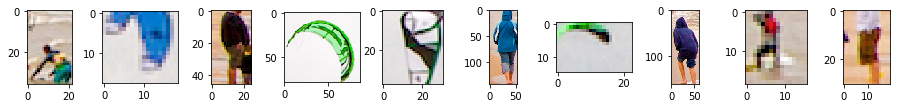

(900, 1352, 3)


In [18]:
#run for all images in path
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  img_copy = load_image_into_numpy_array(image)

  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)

  # Visualization of the results of a detection.
  r_dict = vis_util_new.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  
#   plt.figure(figsize=IMAGE_SIZE)
#   plt.imshow(image_np)
  fig=plt.figure(figsize=(16,16))
  rows = len(r_dict['b_list'])
  
 #****************EDITED PART START ********************#  
  i=1
  for (xmin,xmax,ymin,ymax) in r_dict['b_list']:
    ymin = math.floor(ymin)
    xmin = math.floor(xmin)
    xmax = math.ceil(xmax)
    ymax = math.ceil(ymax)
    print(xmin,xmax,ymin,ymax)
    img = img_copy[ymin:ymax,xmin:xmax]
    fig.add_subplot(rows,rows,i)
    i+=1
    plt.imshow(img)
  
  plt.show()
  print(image_np.shape)
  
  
  #****************END******************************#
  

In [73]:
!cat objectdetector_tf_test/viz_edit.py

# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""A set of functions that are used for visualization.

These functions often receive an image, perform some visualization on the image.
The functions do not return a value, instead they modify the image itself.

"""
import collections
import functools
# Set headless-friendly backend.
import matplotlib; matpl